# Imports

In [2]:
import numpy as np 
import bagpipes as pipes
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from astropy.table import Table
from astropy.io import fits
import h5py
import os
import pandas as pd
os.chdir('/home/research/seds')


# Read in the Data

In [267]:
allcat = Table.read("../github/SummerResearch2023/sedsphot.csv", data_start=1)
virgo_filters_list = np.loadtxt('virgo_filters_list.txt', dtype='str')
#allcat

# Functions to Load Data and Create Galaxy Model & Fit

In [268]:
def load_data(ID):
    
    # reads in file containing galaxy data
    allcat = Table.read("../github/SummerResearch2023/sedsphot.csv", data_start=1)
    
    # converts IDs to integers if needed
    cat = allcat[allcat['VFID'] == int(ID)]
    
    # set band names for calling columns in dataset
    bands = ['FUV', 'NUV', 'G', 'R', 'Z', 'W1', 'W2', 'W3', 'W4']
    nbands = len(bands)
    
    # takes out fluxes and invariances for bands required to calculate photometry
    nanomaggies = np.array([cat[f'FLUX_AP06_{band}'] for band in bands])        
    ivarmaggies = np.array([cat[f'FLUX_IVAR_AP06_{band}'] for band in bands])
    
    # takes the index of the galaxies that have invariances greater than 0 
    # will not take negative invariances to calculate error
    # good = np.where((nanomaggies >= 0) * (ivarmaggies > 0))[0]

    fluxes = np.zeros_like(nanomaggies)
    fluxerrs = np.zeros_like(fluxes) + 1e32

    
    # converts from nanomaggies to microJy and appends them to fluxes
    non_zero_indices = np.where((nanomaggies != 0.0) * (ivarmaggies != 0.0))[0]
    
    factor = 1e-9 * 10**(-0.4 * 48.6) * 1e23 * 1e6
    fluxes[non_zero_indices] = factor * nanomaggies[non_zero_indices]  
    fluxerrs[non_zero_indices] = factor / np.sqrt(ivarmaggies[non_zero_indices])

    photometry = np.c_[fluxes, fluxerrs]

    return photometry                    

In [294]:
def stmasscalc(plots = False):
    '''
    
    '''
    c=3e8
    galid = np.array(allcat['VFID'])
    vr = np.array(allcat['vr'])

    exp = {}                                  # Tau-model star-formation history component
    exp["age"] = (0.1, 15.)                   # Vary age between 100 
                                                #r and 15 Gyr. In practice 
                                              # the code automatically limits this to the age of
                                              # the Universe at the observed redshift.

    exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
    exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
    exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

    dust = {}                                 # Dust component
    dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
    dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

    fit_instructions = {}                     # The fit instructions dictionary
    fit_instructions["exponential"] = exp   
    fit_instructions["dust"] = dust
    
    stmass = []
    sfr = []
    magphys_stmass = []
    magphys_sfr = []
    
    N=len(allcat)
    stmass_unc = np.empty((2,N))
    
    #stmass_unc = []
    
    sfr_unc = []
    
    #virgo_filters_list = np.loadtxt('virgo_filters_list.txt', dtype='str')
        
    for i in range(len(allcat)): 
        
        #if galid[i] in invalid:
        #    continue
        
        recessionVel=vr[i]*1e3 # convert km/s to m/s
        
        z=recessionVel/c # calcs redshift by dividing recession vel by s.o.l.
        
        #######
        
        # mstar,sfr = calc1gal(str(galID[i]),z)
        
        galaxy = pipes.galaxy(str(galid[i]), load_data, spectrum_exists=False, filt_list=virgo_filters_list)
        
        if plots == True:
            fig = galaxy.plot()
        
        fit_instructions["redshift"] = z
        
        
        fit = pipes.fit(galaxy, fit_instructions)
        fit.fit(verbose=False)
        
        ########
        
        sixtnth,eightyfrth = np.percentile(fit.posterior.samples['stellar_mass'] , (16,84))
        median = np.median(fit.posterior.samples["stellar_mass"])
        
        plusunc = eightyfrth - median
        minusunc = median - sixtnth
        
        stmass_unc[0,i] = plusunc
        stmass_unc[1,i] = minusunc
        
        #uncert = np.array([minusunc, plusunc])
        
        #stmass_unc.append(uncert)
        
        stmass.append(np.median(fit.posterior.samples["stellar_mass"]))
        sfr.append(np.median(np.log10(fit.posterior.samples["sfr"])))# - fit.posterior.samples["stellar_mass"]))
        
        magphys_stmass.append(allcat['logMstar'][i])
        magphys_sfr.append(allcat['logSFR'][i])
        
        
    #fig = fit.plot_spectrum_posterior(save=False, show=True)
    #fig = fit.plot_sfh_posterior(save=False, show=True)
    #fig = fit.plot_corner(save=False, show=True)
    
    stmass = np.array(stmass)
    #stmass_unc = np.array(stmass_unc)
    sfr = np.array(sfr)
    
    magphys_stmass = np.array(magphys_stmass)
    magphys_sfr = np.array(magphys_sfr)
    
    return stmass, stmass_unc, magphys_stmass, sfr, magphys_sfr

In [339]:
def calc1gal(ID, vr):
    
    exp = {}                                  # Tau-model star-formation history component
    exp["age"] = (0.1, 15.)                   # Vary age between 100 
                                                #r and 15 Gyr. In practice 
                                              # the code automatically limits this to the age of
                                              # the Universe at the observed redshift.

    exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
    exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
    exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

    dust = {}                                 # Dust component
    dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
    dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

    fit_instructions = {}                     # The fit instructions dictionary
    fit_instructions["exponential"] = exp   
    fit_instructions["dust"] = dust
    
    recessionVel=vr*1e3 # convert km/s to m/s
    z=recessionVel/3e8 # calcs redshift by dividing recession vel by s.o.l.

    fit_instructions["redshift"] = z  
        
    
    galaxy = pipes.galaxy(str(ID), load_data, spectrum_exists=False, filt_list=virgo_filters_list)
        
    fit = pipes.fit(galaxy, fit_instructions)
    fit.fit(verbose=False)
    
    stmass = np.median(fit.posterior.samples["stellar_mass"])
    sfr = np.median(np.log10(fit.posterior.samples["sfr"]))
        
    
    fig = galaxy.plot()
    #fig = fit.plot_spectrum_posterior(save=False, show=True)
    #fig = fit.plot_sfh_posterior(save=False, show=True)
    fig = fit.plot_corner(save=True, show=True)
    
    return stmass, sfr

# Calling the Function to get Stellar Masses

In [295]:
stmass, stmass_unc, magphys_stmass, sfr, magphys_sfr = stmasscalc()


Results loaded from pipes/posterior/./1.h5

Fitting not performed as results have already been loaded from pipes/posterior/./1.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./2.h5

Fitting not performed as results have already been loaded from pipes/posterior/./2.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./3.h5

Fitting not performed as results have already been loaded from pipes/posterior/./3.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./4.h5

Fitting not performed as results have already been loaded from pipes/posterior/./4.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./5.h5

Fitting not performed as results have already been loaded from pipes/posterior/./5.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./6.h5

Fitting not performed as results have already been loaded fr


Results loaded from pipes/posterior/./49.h5

Fitting not performed as results have already been loaded from pipes/posterior/./49.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./50.h5

Fitting not performed as results have already been loaded from pipes/posterior/./50.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./51.h5

Fitting not performed as results have already been loaded from pipes/posterior/./51.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./52.h5

Fitting not performed as results have already been loaded from pipes/posterior/./52.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./53.h5

Fitting not performed as results have already been loaded from pipes/posterior/./53.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./54.h5

Fitting not performed as results have already bee


Results loaded from pipes/posterior/./97.h5

Fitting not performed as results have already been loaded from pipes/posterior/./97.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./98.h5

Fitting not performed as results have already been loaded from pipes/posterior/./98.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./99.h5

Fitting not performed as results have already been loaded from pipes/posterior/./99.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./100.h5

Fitting not performed as results have already been loaded from pipes/posterior/./100.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./101.h5

Fitting not performed as results have already been loaded from pipes/posterior/./101.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./102.h5

Fitting not performed as results have alread


Results loaded from pipes/posterior/./142.h5

Fitting not performed as results have already been loaded from pipes/posterior/./142.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./143.h5

Fitting not performed as results have already been loaded from pipes/posterior/./143.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./144.h5

Fitting not performed as results have already been loaded from pipes/posterior/./144.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./145.h5

Fitting not performed as results have already been loaded from pipes/posterior/./145.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./146.h5

Fitting not performed as results have already been loaded from pipes/posterior/./146.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./147.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./187.h5

Fitting not performed as results have already been loaded from pipes/posterior/./187.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./188.h5

Fitting not performed as results have already been loaded from pipes/posterior/./188.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./189.h5

Fitting not performed as results have already been loaded from pipes/posterior/./189.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./190.h5

Fitting not performed as results have already been loaded from pipes/posterior/./190.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./191.h5

Fitting not performed as results have already been loaded from pipes/posterior/./191.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./192.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./232.h5

Fitting not performed as results have already been loaded from pipes/posterior/./232.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./233.h5

Fitting not performed as results have already been loaded from pipes/posterior/./233.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./234.h5

Fitting not performed as results have already been loaded from pipes/posterior/./234.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./235.h5

Fitting not performed as results have already been loaded from pipes/posterior/./235.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./236.h5

Fitting not performed as results have already been loaded from pipes/posterior/./236.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./237.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./277.h5

Fitting not performed as results have already been loaded from pipes/posterior/./277.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./278.h5

Fitting not performed as results have already been loaded from pipes/posterior/./278.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./279.h5

Fitting not performed as results have already been loaded from pipes/posterior/./279.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./280.h5

Fitting not performed as results have already been loaded from pipes/posterior/./280.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./281.h5

Fitting not performed as results have already been loaded from pipes/posterior/./281.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./282.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./322.h5

Fitting not performed as results have already been loaded from pipes/posterior/./322.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./323.h5

Fitting not performed as results have already been loaded from pipes/posterior/./323.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./324.h5

Fitting not performed as results have already been loaded from pipes/posterior/./324.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./325.h5

Fitting not performed as results have already been loaded from pipes/posterior/./325.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./326.h5

Fitting not performed as results have already been loaded from pipes/posterior/./326.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./327.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./367.h5

Fitting not performed as results have already been loaded from pipes/posterior/./367.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./368.h5

Fitting not performed as results have already been loaded from pipes/posterior/./368.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./369.h5

Fitting not performed as results have already been loaded from pipes/posterior/./369.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./370.h5

Fitting not performed as results have already been loaded from pipes/posterior/./370.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./371.h5

Fitting not performed as results have already been loaded from pipes/posterior/./371.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./372.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./412.h5

Fitting not performed as results have already been loaded from pipes/posterior/./412.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./413.h5

Fitting not performed as results have already been loaded from pipes/posterior/./413.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./414.h5

Fitting not performed as results have already been loaded from pipes/posterior/./414.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./415.h5

Fitting not performed as results have already been loaded from pipes/posterior/./415.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./416.h5

Fitting not performed as results have already been loaded from pipes/posterior/./416.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./417.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./457.h5

Fitting not performed as results have already been loaded from pipes/posterior/./457.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./458.h5

Fitting not performed as results have already been loaded from pipes/posterior/./458.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./459.h5

Fitting not performed as results have already been loaded from pipes/posterior/./459.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./460.h5

Fitting not performed as results have already been loaded from pipes/posterior/./460.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./461.h5

Fitting not performed as results have already been loaded from pipes/posterior/./461.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./462.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./502.h5

Fitting not performed as results have already been loaded from pipes/posterior/./502.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./503.h5

Fitting not performed as results have already been loaded from pipes/posterior/./503.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./504.h5

Fitting not performed as results have already been loaded from pipes/posterior/./504.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./505.h5

Fitting not performed as results have already been loaded from pipes/posterior/./505.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./506.h5

Fitting not performed as results have already been loaded from pipes/posterior/./506.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./507.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./547.h5

Fitting not performed as results have already been loaded from pipes/posterior/./547.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./548.h5

Fitting not performed as results have already been loaded from pipes/posterior/./548.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./549.h5

Fitting not performed as results have already been loaded from pipes/posterior/./549.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./550.h5

Fitting not performed as results have already been loaded from pipes/posterior/./550.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./551.h5

Fitting not performed as results have already been loaded from pipes/posterior/./551.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./552.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./592.h5

Fitting not performed as results have already been loaded from pipes/posterior/./592.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./593.h5

Fitting not performed as results have already been loaded from pipes/posterior/./593.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./594.h5

Fitting not performed as results have already been loaded from pipes/posterior/./594.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./595.h5

Fitting not performed as results have already been loaded from pipes/posterior/./595.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./596.h5

Fitting not performed as results have already been loaded from pipes/posterior/./596.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./597.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./637.h5

Fitting not performed as results have already been loaded from pipes/posterior/./637.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./638.h5

Fitting not performed as results have already been loaded from pipes/posterior/./638.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./639.h5

Fitting not performed as results have already been loaded from pipes/posterior/./639.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./640.h5

Fitting not performed as results have already been loaded from pipes/posterior/./640.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./641.h5

Fitting not performed as results have already been loaded from pipes/posterior/./641.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./642.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./682.h5

Fitting not performed as results have already been loaded from pipes/posterior/./682.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./683.h5

Fitting not performed as results have already been loaded from pipes/posterior/./683.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./684.h5

Fitting not performed as results have already been loaded from pipes/posterior/./684.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./685.h5

Fitting not performed as results have already been loaded from pipes/posterior/./685.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./686.h5

Fitting not performed as results have already been loaded from pipes/posterior/./686.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./687.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./727.h5

Fitting not performed as results have already been loaded from pipes/posterior/./727.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./728.h5

Fitting not performed as results have already been loaded from pipes/posterior/./728.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./729.h5

Fitting not performed as results have already been loaded from pipes/posterior/./729.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./730.h5

Fitting not performed as results have already been loaded from pipes/posterior/./730.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./731.h5

Fitting not performed as results have already been loaded from pipes/posterior/./731.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./732.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./772.h5

Fitting not performed as results have already been loaded from pipes/posterior/./772.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./773.h5

Fitting not performed as results have already been loaded from pipes/posterior/./773.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./774.h5

Fitting not performed as results have already been loaded from pipes/posterior/./774.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./775.h5

Fitting not performed as results have already been loaded from pipes/posterior/./775.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./776.h5

Fitting not performed as results have already been loaded from pipes/posterior/./776.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./777.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./817.h5

Fitting not performed as results have already been loaded from pipes/posterior/./817.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./818.h5

Fitting not performed as results have already been loaded from pipes/posterior/./818.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./819.h5

Fitting not performed as results have already been loaded from pipes/posterior/./819.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./820.h5

Fitting not performed as results have already been loaded from pipes/posterior/./820.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./821.h5

Fitting not performed as results have already been loaded from pipes/posterior/./821.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./822.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./862.h5

Fitting not performed as results have already been loaded from pipes/posterior/./862.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./863.h5

Fitting not performed as results have already been loaded from pipes/posterior/./863.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./864.h5

Fitting not performed as results have already been loaded from pipes/posterior/./864.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./865.h5

Fitting not performed as results have already been loaded from pipes/posterior/./865.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./866.h5

Fitting not performed as results have already been loaded from pipes/posterior/./866.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./867.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./907.h5

Fitting not performed as results have already been loaded from pipes/posterior/./907.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./908.h5

Fitting not performed as results have already been loaded from pipes/posterior/./908.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./909.h5

Fitting not performed as results have already been loaded from pipes/posterior/./909.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./910.h5

Fitting not performed as results have already been loaded from pipes/posterior/./910.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./911.h5

Fitting not performed as results have already been loaded from pipes/posterior/./911.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./912.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./952.h5

Fitting not performed as results have already been loaded from pipes/posterior/./952.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./953.h5

Fitting not performed as results have already been loaded from pipes/posterior/./953.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./954.h5

Fitting not performed as results have already been loaded from pipes/posterior/./954.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./955.h5

Fitting not performed as results have already been loaded from pipes/posterior/./955.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./956.h5

Fitting not performed as results have already been loaded from pipes/posterior/./956.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./957.h5

Fitting not performed as results have 


Results loaded from pipes/posterior/./997.h5

Fitting not performed as results have already been loaded from pipes/posterior/./997.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./998.h5

Fitting not performed as results have already been loaded from pipes/posterior/./998.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./999.h5

Fitting not performed as results have already been loaded from pipes/posterior/./999.h5. To start over delete this file or change run.


Results loaded from pipes/posterior/./1000.h5

Fitting not performed as results have already been loaded from pipes/posterior/./1000.h5. To start over delete this file or change run.




Results loaded from pipes/posterior/./7.h5

Fitting not performed as results have already been loaded from pipes/posterior/./7.h5. To start over delete this file or change run.



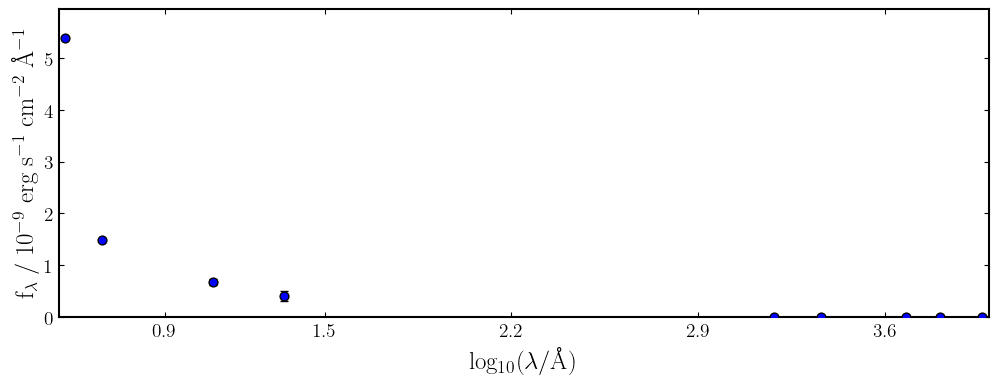

(8.442270059668335, -1.699888534406701)

In [340]:
calc1gal('7',allcat['vr'][6])

# Creating a table of outputs and applying a flag for masses = zero

In [218]:
np.shape(stmass_unc)

(2, 9)

In [234]:
stmass_unc

[array([0.00020923, 0.0001986 ]),
 array([0.00026654, 0.00029686]),
 array([0.00096276, 0.00058976]),
 array([0.00076164, 0.00054279]),
 array([0.00043505, 0.00061774]),
 array([0.00785431, 0.00357094]),
 array([0.00261284, 0.0052426 ]),
 array([0.00012797, 0.0001181 ]),
 array([0.00777424, 0.0142655 ])]

In [296]:
data = {
    'VFID':allcat['VFID'],
    'BP stmass':stmass,
    #'BP stmass uncertainty':stmass_unc,
    'BP stmass +unc':stmass_unc[0],
    'BP stmass -unc':stmass_unc[1],
    'MAGPHYS stmass':magphys_stmass,
    'BP sfr':sfr,
    'MAGPHYS sfr':magphys_sfr
}

df = pd.DataFrame(data)

In [297]:
df

,VFID,BP stmass,BP stmass +unc,BP stmass -unc,MAGPHYS stmass,BP sfr,MAGPHYS sfr
0,1,9.877318,0.000192,0.000220,9.790496,-15.550303,-0.970616
1,2,10.305169,0.000281,0.000285,10.293363,-0.344703,0.086716
2,3,9.528574,0.000549,0.000845,9.581950,-13.601591,-2.541513
3,4,9.058735,0.000543,0.000762,9.254306,-6.746742,-2.404614
4,5,9.721690,0.000566,0.000414,9.673021,-12.470748,-0.828566
...,...,...,...,...,...,...,...
995,996,6.527142,0.004741,0.006476,6.724604,-3.205922,-2.856361
996,997,9.549954,0.001484,0.001591,9.244277,-15.955602,-2.188090
997,998,6.942678,5.056294,4.102886,0.000000,-2.974560,0.000000
998,999,7.844649,0.006020,0.004573,7.790144,-1.767206,-1.607303


In [298]:
flag = df['MAGPHYS stmass'] > 0
df1 = df[flag]  # MAGPHYS stellar masses that are zero that need to be removed from dataset

In [299]:
df1

,VFID,BP stmass,BP stmass +unc,BP stmass -unc,MAGPHYS stmass,BP sfr,MAGPHYS sfr
0,1,9.877318,0.000192,0.000220,9.790496,-15.550303,-0.970616
1,2,10.305169,0.000281,0.000285,10.293363,-0.344703,0.086716
2,3,9.528574,0.000549,0.000845,9.581950,-13.601591,-2.541513
3,4,9.058735,0.000543,0.000762,9.254306,-6.746742,-2.404614
4,5,9.721690,0.000566,0.000414,9.673021,-12.470748,-0.828566
...,...,...,...,...,...,...,...
994,995,7.694273,0.013715,0.008733,7.722140,-2.546683,-2.246494
995,996,6.527142,0.004741,0.006476,6.724604,-3.205922,-2.856361
996,997,9.549954,0.001484,0.001591,9.244277,-15.955602,-2.188090
998,999,7.844649,0.006020,0.004573,7.790144,-1.767206,-1.607303


# Calculate Positive and Negative Residuals

In [275]:
stmass_residual = df1['BP stmass'] - df1['MAGPHYS stmass']
sfr_residual = df1['BP sfr'] - df1['MAGPHYS sfr']

In [331]:
outlier = np.abs(stmass_residual) > 1
stmass_residual[outlier]

112    -6.749474
160     2.420348
209     1.042306
320    -1.052451
347    -1.287611
429     1.471309
510     1.121391
542     1.771198
625     1.285195
711    -1.424452
719    -1.332361
875   -10.502482
dtype: float64

In [334]:
df1[outlier]

,VFID,BP stmass,BP stmass +unc,BP stmass -unc,MAGPHYS stmass,BP sfr,MAGPHYS sfr
112,113,2.052193,1.046287,0.908018,8.769746,-8.015968,-1.708853
160,161,8.417513,0.006061,0.004951,5.997430,-14.529411,-1.966174
209,210,9.113454,0.000133,0.000132,8.071145,-0.659450,-3.061881
320,321,9.615164,0.002013,0.000307,10.667640,-0.840622,-2.200797
347,348,7.671560,0.002220,0.002345,8.959137,-0.218742,-1.464959
429,430,9.114527,0.003154,0.004094,7.643058,-11.185073,-3.633204
510,511,10.041722,0.000022,0.000047,8.920332,0.929781,0.999870
542,543,11.089893,0.000161,0.000158,9.318689,-16.130990,-0.860121
625,626,9.807590,0.002033,0.002061,8.522314,-15.585228,-1.758205
711,712,9.058830,0.000383,0.000419,10.483302,1.118411,1.314499


In [305]:
stmass_unc = np.array([df1['BP stmass -unc'],df1['BP stmass +unc']])
np.shape(stmass_unc)

(2, 937)

# Plot Stellar Masses and Compare

In [277]:
t = np.array(stmass_unc)
print(t.shape)
t[0]
stmass_unc = np.array(stmass_unc)

(1000, 2)


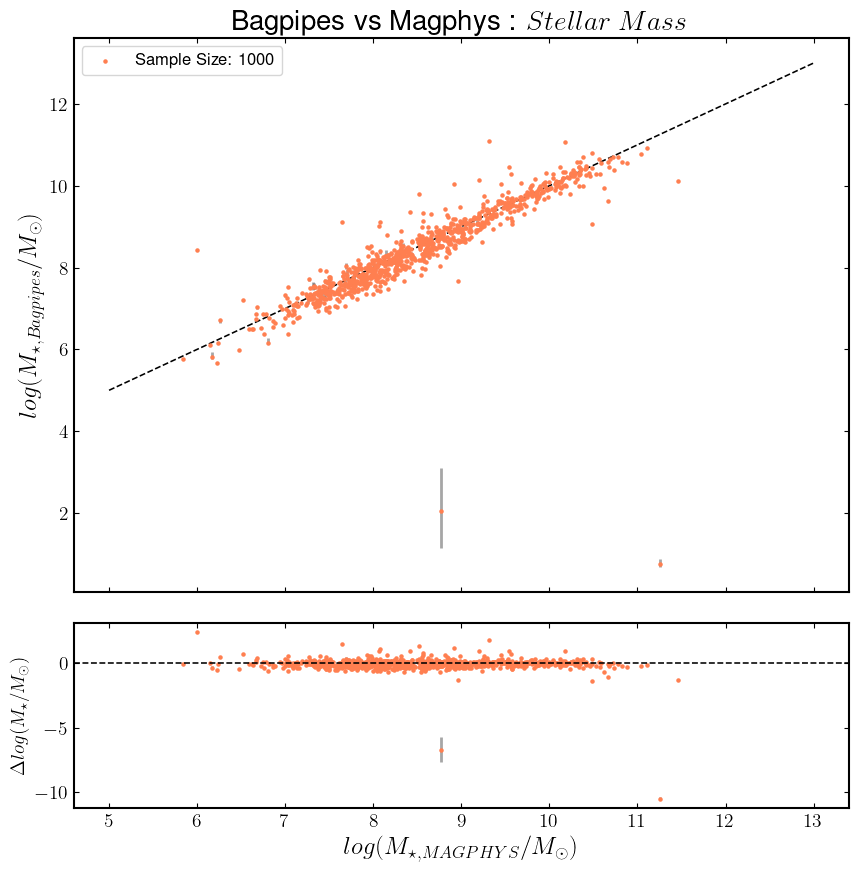

In [330]:
x=np.linspace(5,13,2); y=x

fig,ax=plt.subplots(2,1,sharex=True,
                      gridspec_kw=dict(height_ratios=[6,2]),
                      figsize=(10,10))

ax[0].plot(x,y, 'k--', linewidth = 1.15)

ax[0].errorbar(df1['MAGPHYS stmass'], df1['BP stmass'],
               yerr=stmass_unc,
               markersize=1,
               fmt='None',
               ecolor='black',alpha=0.35,
              zorder=1)



ax[0].scatter(df1['MAGPHYS stmass'], df1['BP stmass'], s=5 , c='coral',zorder=10,
              label=f'Sample Size: {len(stmass)}')
#ax[0].set_ylim(6,11); ax[0].set_xlim(6,11)
ax[0].set_ylabel('$log(M_{\star, Bagpipes}/M_{\odot})$')
ax[0].set_title('Bagpipes vs Magphys : $Stellar$ $Mass$', fontsize = 20)
ax[0].legend(fontsize=12)


ax[1].errorbar(df1['MAGPHYS stmass'], stmass_residual,
               yerr=stmass_unc,
               markersize=1,
               fmt='None',
               ecolor='black',alpha=0.35,
              zorder=1)



ax[1].axhline(0, color = 'black', linestyle = '--', linewidth=1.15)
ax[1].scatter(df1['MAGPHYS stmass'],stmass_residual,s=5,c='coral')
#ax[1].set_ylim(-1,1); ax[1].set_xlim(6,11)
ax[1].set_xlabel('$log(M_{\star, MAGPHYS}/M_{\odot})$')
ax[1].set_ylabel('$\Delta log(M_{\star}/M_{\odot})$', fontsize = 14)

fig.subplots_adjust(hspace=0.085)

plt.show()

In [188]:
df1['BP stmass']

0     9.877333
1    10.305171
2     9.528510
3     9.058735
4     9.721675
5     8.892570
6     8.441883
7    10.283822
8     8.655769
Name: BP stmass, dtype: float64

In [203]:
np.shape(df1['BP stmass uncertainty'][0])

(2,)

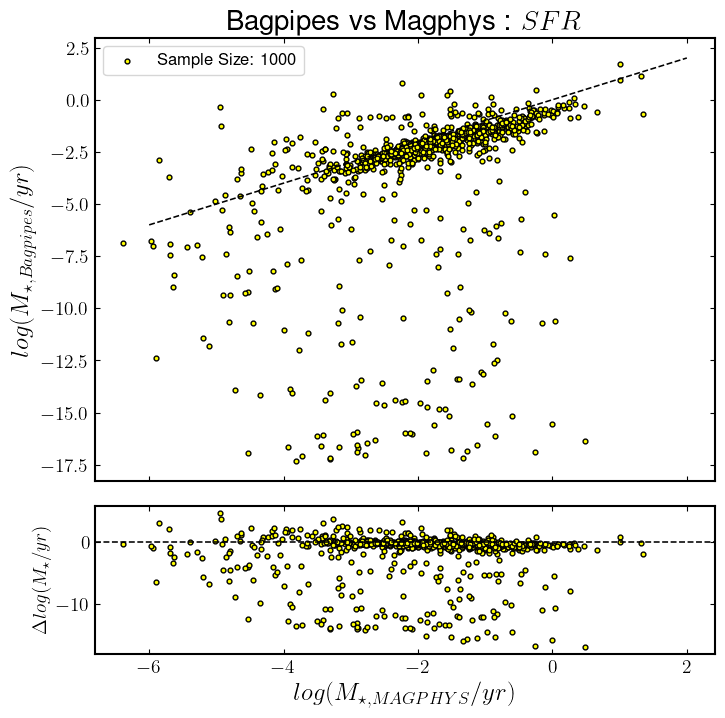

In [336]:
x = np.linspace(-6,2,2); y=x

fig,ax = plt.subplots(2,1,sharex=True,
                      gridspec_kw=dict(height_ratios=[6,2]),
                      figsize=(8,8))

ax[0].plot(x,y, 'k--', linewidth = 1.15)
ax[0].scatter(df1['MAGPHYS sfr'], df1['BP sfr'], s=12, c='yellow', edgecolors='black', label=f'Sample Size: {len(sfr)}')
#ax[0].set_ylim(-5,1); ax[0].set_xlim(-5,1)
ax[0].set_ylabel('$log(M_{\star, Bagpipes}/yr)$')
ax[0].set_title('Bagpipes vs Magphys : $SFR$', fontsize = 20)
ax[0].legend(fontsize=12)

ax[1].axhline(0, color = 'black', linestyle = '--', linewidth=1.15)
ax[1].scatter(df1['MAGPHYS sfr'] , sfr_residual, s=12, c='yellow', edgecolors='black')
#ax[1].set_ylim(-2,2); ax[1].set_xlim(-5,1)
ax[1].set_xlabel('$log(M_{\star, MAGPHYS}/yr)$')
ax[1].set_ylabel('$\Delta log(M_{\star}/yr)$', fontsize = 14)

fig.subplots_adjust(hspace=0.085)

plt.show()

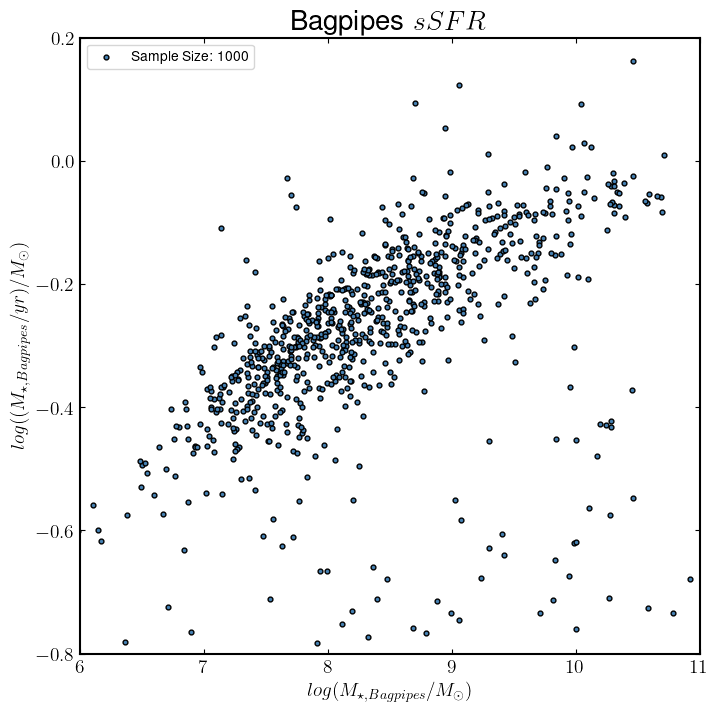

In [338]:
ssfr = df1['BP sfr'] / df1['BP stmass']

plt.figure(figsize=(8,8))
plt.scatter(df1['BP stmass'], ssfr, s = 12, c='steelblue', edgecolors='black', label=f'Sample Size: {len(sfr)}')
plt.title('Bagpipes $sSFR$', fontsize = 20)
plt.xlabel('$log(M_{\star, Bagpipes}/M_{\odot})$', fontsize = 14)
plt.ylabel('$log((M_{\star, Bagpipes}/yr)/M_{\odot})$', fontsize=14)

plt.ylim(-.8,.2) ; plt.xlim(6,11) 

_=plt.legend()

##

# TESTING below... yo

##

In [37]:
abmag = -2.5 * np.log10(59.826419830322266 * 1e-9)
10**(-0.4 * (48.6 - abmag)) * 1e6, 59.826419830322266 * 1e6 * 1e-9 * 10**(-0.4 * 48.6)

(6.068858136586664e-07, 2.172166013585276e-21)

In [38]:
1e-9 * 59.826419830322266 * 10**(-0.4 * 48.6) * 1e26 * 1e6

217216.6013585276

In [39]:
pp = load_data('7')
pp

array([[2.17216601e+02, 7.82557447e+00],
       [3.64277743e+02, 6.10427091e+00],
       [2.17405462e+03, 3.72148582e+00],
       [3.20247276e+03, 7.58917836e+00],
       [3.32098216e+03, 9.65301383e+00],
       [2.03742013e+03, 8.08262003e+00],
       [1.05659548e+03, 1.50181285e+01],
       [3.31084837e+03, 2.99944026e+02],
       [6.69868418e+03, 1.49629626e+03]])

In [72]:
abmag = 22.5 - 2.5 * np.log10(allcat['FLUX_AP06_FUV'][4])
10**(-0.4 * (48.6 - abmag)) * 1e6
#cat['FLUX_AP06_FUV'][1] * 3.631

1.7251322375435594e-07

In [25]:
#stmass1, sfr1 = calc1gal('7',allcat['vr'][6])

In [27]:
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 
                                                #r and 15 Gyr. In practice 
                                              # the code automatically limits this to the age of
                                              # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust
    
recessionVel=allcat['vr'][6]*1e3 # convert km/s to m/s
z=recessionVel/3e8 # calcs redshift by dividing recession vel by s.o.l.

fit_instructions["redshift"] = z  



galaxy = pipes.galaxy('7', load_data, spectrum_exists=False, filt_list=virgo_filters_list)
fit = pipes.fit(galaxy, fit_instructions)
fit.fit(verbose=False)
    


Results loaded from pipes/posterior/./7.h5

Fitting not performed as results have already been loaded from pipes/posterior/./7.h5. To start over delete this file or change run.



In [28]:
sixtnth,eightyfrth = np.percentile(fit.posterior.samples['stellar_mass'] , (16,84))
median = np.median(fit.posterior.samples["stellar_mass"])

In [29]:
pluserr = eightyfrth - median
minuserr = median - sixtnth
testerr = np.array([[minuserr], [pluserr]])
testerr

array([[0.0024468 ],
       [0.00483627]])

<ErrorbarContainer object of 3 artists>

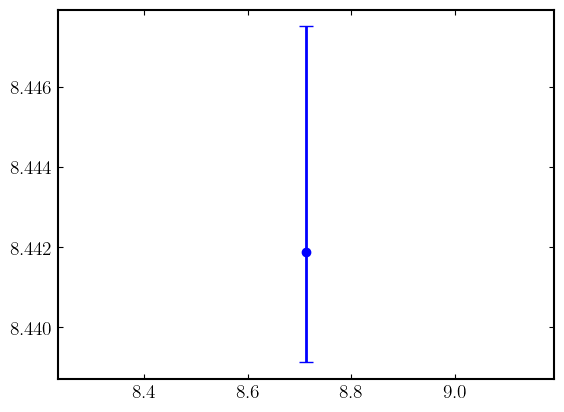

In [476]:
plt.figure()
plt.errorbar(df1['MAGPHYS stmass'][6], df1['BP stmass'][6], yerr = testerr, capsize = 5 ,fmt='bo')
